In [19]:
from era_okid_tools import *

# Logistics
warnings.simplefilter("ignore", UserWarning)
sympy.init_printing()
figs_dir = (Path.cwd() / "figs")
data_dir = (Path.cwd() / "data")

In [20]:
train_data = np.load(data_dir / f"data_train.npz")
t_train = train_data["t"].squeeze()
U_train = train_data["U"]
Z_train = train_data["Z"]

test_data = np.load(data_dir / f"data_test.npz")
t_test = test_data["t"].squeeze()
U_test = test_data["U"]
Z_test = test_data["Z"]

# Simulation dimensions
n = 6 # Number of desired states
r = U_train.shape[0] # Number of inputs
m = Z_train.shape[0] # Number of measurements
t_max = t_train[-1] # Total simulation time
dt = t_train[1] - t_train[0] # Simulation timestep duration
nt = t_train.shape[0] # Number of simulation timesteps

# OKID logistics
order = 30 # Observer order for OKID
alpha, beta = 15, 10 # Number of block rows and columns in Hankel matrices
n_era = 6 # Number of proposed states
X_0 = np.zeros([n_era, 1]) # Zero initial condition

print(f"Min. OKID Order: {max([alpha + beta, (n_era/m) + (n_era/r)]):n}")
print(f"Max. OKID Order: {(nt - r)/(r + m):n}")
print(f"Proposed OKID Order: {order:n}")

Min. OKID Order: 25
Max. OKID Order: 12.25
Proposed OKID Order: 30


Rank of H(0): 20
Rank of H(1): 20


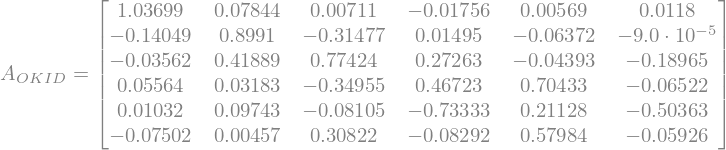

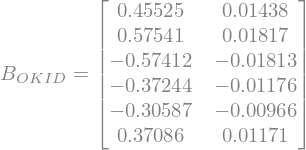

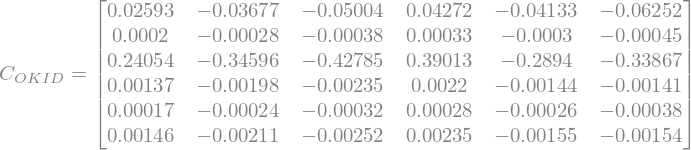

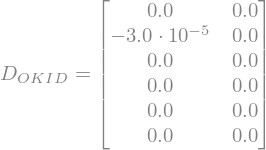

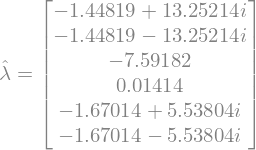

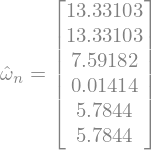

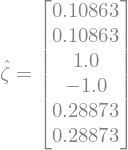

In [21]:
# Identify System Markov parameters and Observer Gain Markov parameters
Y_okid, Y_og_okid = okid(Z_train, U_train,
                         l_0 = order, alpha = alpha, beta = beta, n = n_era)
# Identify state space model using System Markov parameters for ERA
A_okid, B_okid, C_okid, D_okid, S_okid = \
    era(Y_okid, alpha = alpha, beta = beta, n = n_era)
X_okid_train, Z_okid_train = \
    sim_ss(A_okid, B_okid, C_okid, D_okid,
           X_0 = X_0, U = U_train, nt = nt)
# Display outputs
etch(f"A_{{OKID}}", A_okid)
etch(f"B_{{OKID}}", B_okid)
etch(f"C_{{OKID}}", C_okid)
etch(f"D_{{OKID}}", D_okid)
# Calculate and display eigenvalues
eig_A_okid = spla.eig(d2c(A_okid, B_okid, dt)[0])[0] # Eigenvalues of identified system
etch(f"\hat{{\lambda}}", eig_A_okid)
etch(f"\hat{{\omega}}_{{n}}", np.abs(eig_A_okid))
etch(f"\hat{{\zeta}}", -np.cos(np.angle(eig_A_okid)))
X_okid_test, Z_okid_test = \
    sim_ss(A_okid, B_okid, C_okid, D_okid,
           X_0 = X_0, U = U_test, nt = nt)

In [22]:
RMS_train = np.sqrt(np.mean((Z_okid_train - Z_train)**2, axis = 1))
print(f"RMS Error of sim. for system found via OKID for train data: {RMS_train}")
RMS_test = np.sqrt(np.mean((Z_okid_test - Z_test)**2, axis = 1))
print(f"RMS Error of sim. for system found via OKID for test data: {RMS_test}")

RMS Error of sim. for system found via OKID for train data: [14.66437687  0.84248009  9.47542026  0.05990548  0.05153518  0.06319343]
RMS Error of sim. for system found via OKID for test data: [13.60661274  3.5882413   9.29130234  0.11477739  0.27909333  0.12654084]


In [23]:
# Eigenvalue plots
fig, ax = plt.subplots(constrained_layout = True) # type:figure.Figure
fig.suptitle(f"OKID: Eigenvalues", fontweight = "bold")

ax.plot(np.real(eig_A_okid), np.imag(eig_A_okid),
         "s", mfc = "None")

fig.savefig(figs_dir / f"okid_eigval.pdf",
            bbox_inches = "tight")

# Singular Value plots
fig, ax = plt.subplots(constrained_layout = True) # type:figure.Figure
fig.suptitle(f"OKID: Singular Values", fontweight = "bold")

ax.semilogy(np.linspace(1, len(S_okid), len(S_okid)), S_okid,
         "o", mfc = "None")
plt.setp(ax, xlabel = f"Singular Value", ylabel = f"Value",
         xticks = np.arange(1, len(S_okid) + 1))

fig.savefig(figs_dir / f"okid_singval.pdf",
            bbox_inches = "tight")

# Response plots
ms = 0.5 # Marker size
fig, axs = plt.subplots((r + n_era)//2, 2,
                        sharex = "col",
                        constrained_layout = True) # type:figure.Figure
fig.suptitle(f"OKID: State Responses",
             fontweight = "bold")

for i in range(r):
    axs[0][i].plot(t_train, U_train[i, :])
    plt.setp(axs[0][i], ylabel = f"$u_{i + 1}$", xlim = [0, t_max])

for i, state_ax in zip(range(n_era), axs[1:].flat):
    state_ax.plot(t_train, X_okid_train[i, :-1])
    plt.setp(state_ax, ylabel = f"$x_{i + 1}$", xlim = [0, t_max])
    if (i == (n_era - 1)) or (i == n_era):
        plt.setp(state_ax, xlabel = f"Time")
fig.savefig(figs_dir / f"okid_states.pdf",
            bbox_inches = "tight")

# Observation plots
fig, axs = plt.subplots(m//2, 2,
                        sharex = "col",
                        constrained_layout = True) # type:figure.Figure
fig.suptitle(f"OKID: Observation Responses",
             fontweight = "bold")

for i, obs_ax in zip(range(m), axs.flat):
    obs_ax.plot(t_train, Z_train[i, :])
    obs_ax.plot(t_train, Z_okid_train[i, :],
                "o", ms = ms, mfc = "None")
    plt.setp(obs_ax, ylabel = f"$z_{i + 1}$", xlim = [0, t_max])
    if (i == (m - 1)) or (i == m):
        plt.setp(obs_ax, xlabel = f"Time")
fig.legend(labels = ["True", "OKID"],
           bbox_to_anchor = (1, 0.5), loc = 6)
fig.savefig(figs_dir / f"okid_obs.pdf",
            bbox_inches = "tight")

# Observation error plots
fig, axs = plt.subplots(m//2, 2,
                        sharex = "col",
                        constrained_layout = True) # type:figure.Figure
fig.suptitle(f"OKID: Error in Observation Responses",
             fontweight = "bold")

for i, obs_ax in zip(range(m), axs.flat):
    obs_ax.plot(t_train, abs(Z_okid_train[i, :] - Z_train[i, :]))
    plt.setp(obs_ax, ylabel = f"$z_{i + 1}$", xlim = [0, t_max])
    if (i == (m - 1)) or (i == m):
        plt.setp(obs_ax, xlabel = f"Time")
fig.savefig(figs_dir / f"okid_obs_error.pdf",
            bbox_inches = "tight")

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 8 Axes>

<Figure size 640x480 with 6 Axes>

<Figure size 640x480 with 6 Axes>